# Downloading, pre-processing and running cNMF on Schlesinger et. al 2020data
1. Obtaining the count matrix and complementary metadata

2. filtering genes, selecting joint highly variable genes (HVGs) and showing key statistics

3. Splitting the dataset by time after tumor induction, and selecting HVG per time

3. Running consensus NMF (cNMF) per stage

4. Selecting parameters for the cNMF 



In [1]:
%%time
%load_ext autoreload
%autoreload 2

#debug:
from importlib import reload

import sys
import os
import time
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
from scipy import sparse
import scanpy as sc
import matplotlib.pyplot as plt

from gepdynamics import _utils
from gepdynamics import _constants
from gepdynamics import cnmf
from gepdynamics import comparator

_utils.cd_proj_home()
print(os.getcwd())


/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 2.12 s, sys: 891 ms, total: 3.01 s
Wall time: 7.95 s


In [151]:
from gepdynamics import comparator

### Downloading and loading AnnData object

In [74]:
%%time

results_dir = _utils.set_dir('results_schlesinger')

orig_adata_path = results_dir.joinpath('GSE141017_ALL.h5ad')

if not orig_adata_path.exists():  # create the original adata if it doesn't exist
    # directories for file download:
    data_dir = _utils.set_dir('data')
    GSE_dir = _utils.set_dir(data_dir.joinpath('GSE141017'))
    
    # GEO server prefix for PDAC Series GSE141017
    ftp_address = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE141nnn/GSE141017/suppl/'

    #filenames
    f_raw_data = GSE_dir.joinpath('GSE141017_ALL.csv.gz')
    f_barcodes_ident = GSE_dir.joinpath('GSE141017_ALL_barcode_ident.csv.gz')

    # downloading if needed:
    if not f_raw_data.exists():
        urlretrieve(ftp_address + f_raw_data.name, f_raw_data)
    
    if not f_barcodes_ident.exists():
        urlretrieve(ftp_address + f_barcodes_ident.name, f_barcodes_ident)

    barcodes_ident = pd.read_csv(f_barcodes_ident, index_col=0, sep='\t', 
                                 dtype={'ident': 'category', 'time_point': 'category'})
    
    # fixing the barcode identities dataframe to match raw data
    barcodes_ident.index = barcodes_ident.index.str.replace('.', '-', regex=False).str.replace('^X', '', regex=True)
    
    # changing categories display order
    barcodes_ident.time_point = barcodes_ident.time_point.cat.reorder_categories(
        ['CTRL', '17D', '6W', '3M', '5M', '9M', '15M', ])
    barcodes_ident.ident = barcodes_ident.ident.cat.reorder_categories(
        [str(i) for i in range(27)])
    
    # loading the raw data as np.float32
    dtype_dict = {col: np.float32 for col in barcodes_ident.index}
    raw_data = pd.read_csv(f_raw_data, index_col=0, sep='\t', dtype=dtype_dict)
    
    # constructing the adata
    adata = sc.AnnData(X=raw_data.T, dtype=np.float32, obs=barcodes_ident)
    
    adata.X = sparse.csr_matrix(adata.X)
    
    adata.write(orig_adata_path)
    
    del raw_data, barcodes_ident   
else:
    adata = sc.read(orig_adata_path)

print(f'Density of data = {(adata.X.size) / (adata.shape[0] * adata.shape[1]): .4f}')
adata

Density of data =  0.0867
CPU times: user 137 ms, sys: 386 ms, total: 523 ms
Wall time: 8.85 s


AnnData object with n_obs × n_vars = 41139 × 19514
    obs: 'ident', 'time_point'

In [75]:
pd.crosstab(adata.obs.ident, adata.obs.time_point)

time_point,CTRL,17D,6W,3M,5M,9M,15M
ident,,,,,,,
0,1380,805,1003,823,1297,78,63
1,184,148,290,1345,1303,66,989
2,42,39,90,1184,1958,319,299
3,1575,1044,547,212,326,2,16
4,0,2,49,723,849,419,1109
5,42,42,117,1030,356,274,931
6,1011,775,755,74,37,0,0
7,0,0,0,0,2,7,2465
8,42,46,153,517,1385,23,11


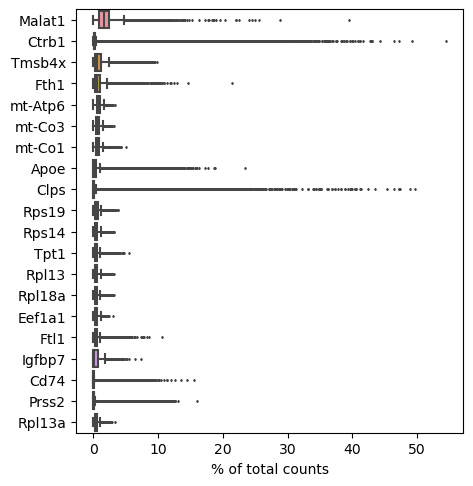

In [76]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Filter genes and plot basic statistics
The cells were pre-filtered to:
1. A minimum of 1000 counts and 200 genes.
2. Cells with more than 5% (most) or 10% (9M, 15M) mitochondrial genes were removed
3. Cells with more than 6000 genes were removed

We add filtering to have:
1. Remove cells with more than 40,000 counts
2. Remove genes appearing in less than 4 cells


In [78]:
%%time
print(f'before filtering shape was {adata.X.shape}')

# filtering genes with very low abundance
sc.pp.filter_genes(adata, min_cells=np.round(adata.shape[0] / 10000))

# getting general statistics for counts abundance
sc.pp.filter_genes(adata, min_counts=0)
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_cells(adata, max_counts=4e4)
sc.pp.filter_cells(adata, min_genes=0)

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

print(f'after filtering shape is {adata.X.shape}')

adata

before filtering shape was (41057, 18699)
after filtering shape is (41057, 18689)
CPU times: user 2.86 s, sys: 704 ms, total: 3.57 s
Wall time: 3.15 s


AnnData object with n_obs × n_vars = 41057 × 18689
    obs: 'ident', 'time_point', 'n_counts', 'n_genes'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

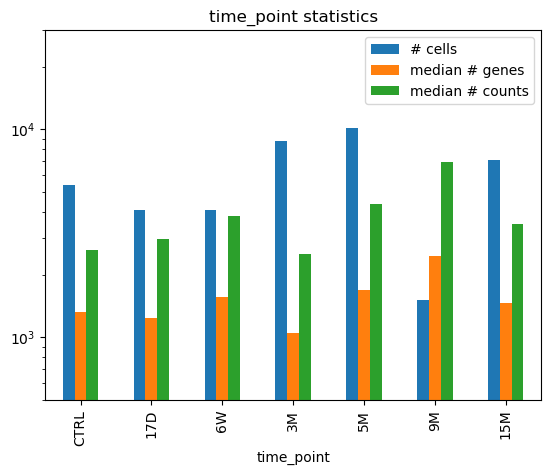

In [7]:
column_of_interest = 'time_point'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((5e2, 3e4)))
plt.show()
del column_of_interest, stats_df

13 mitochondrial genes


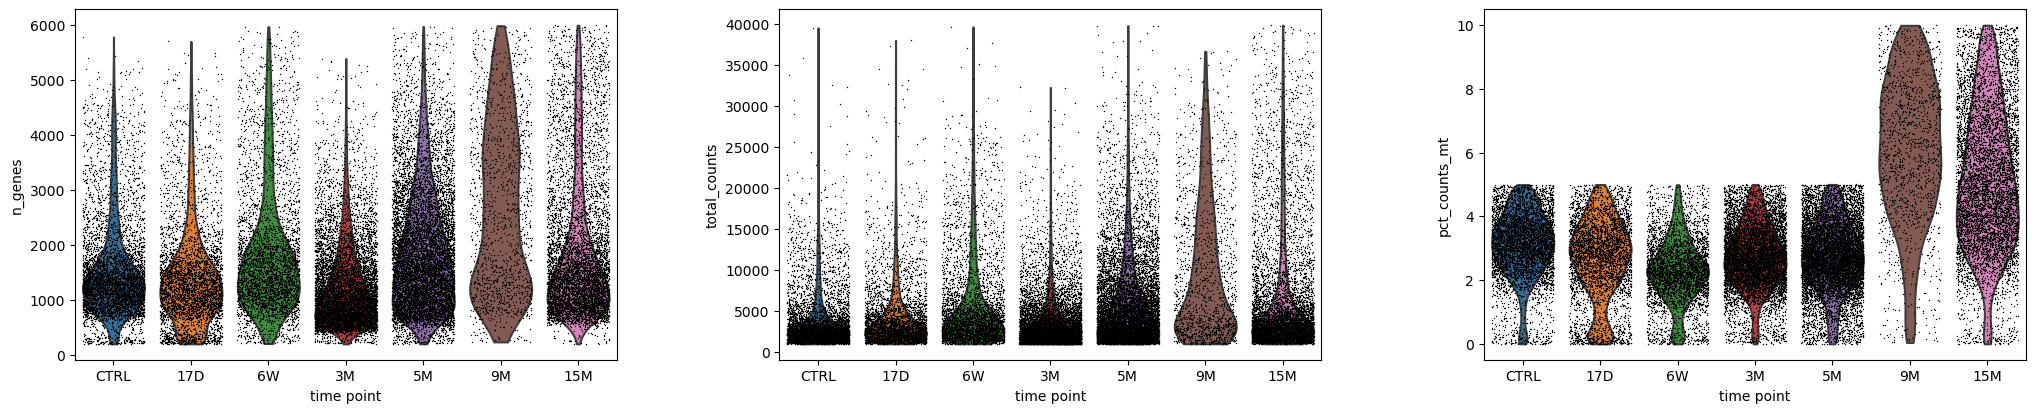

In [82]:
# From scanpy tutorial:

adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
print(f"{np.sum(adata.var['mt'])} mitochondrial genes")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt',],
             jitter=0.4, multi_panel=True, groupby='time_point')

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


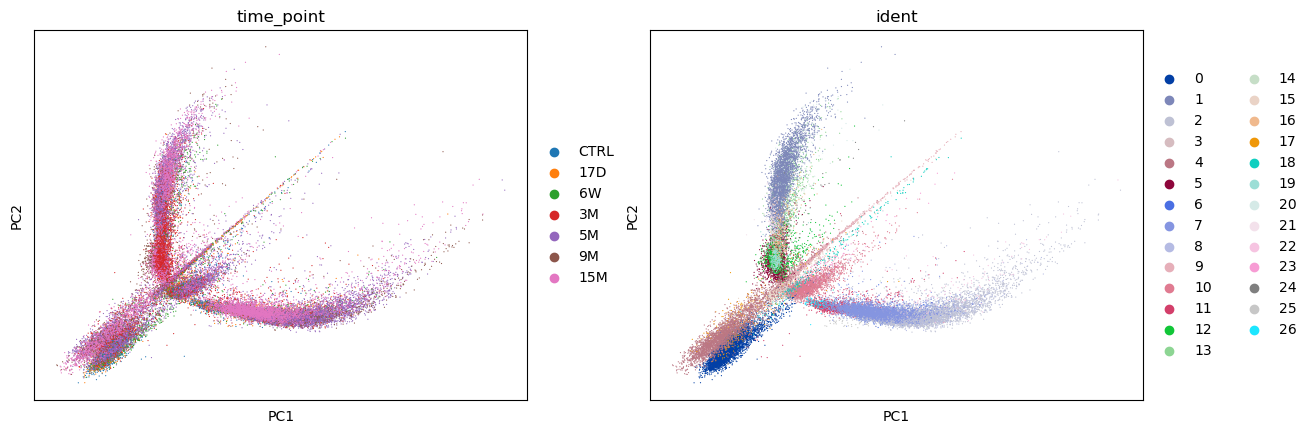

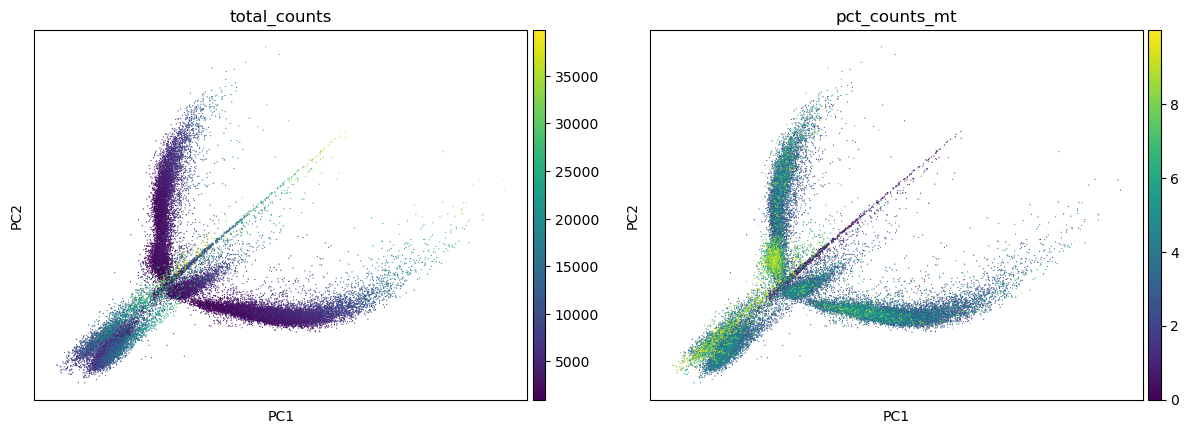

CPU times: user 2min 28s, sys: 3min 38s, total: 6min 6s
Wall time: 39.7 s


In [93]:
%%time
bdata = adata[:, adata.var.highly_variable].copy()

sc.pp.normalize_total(bdata, target_sum=1e4)
sc.pp.log1p(bdata)
sc.pp.regress_out(bdata, ['total_counts']) # The pct_counts_mt regression was removed as it correlates with time 
sc.pp.scale(bdata, max_value=20)

sc.tl.pca(bdata, svd_solver='arpack', n_comps=100)
sc.pl.pca(bdata, color=['time_point', 'ident'])
sc.pl.pca(bdata, color=['total_counts', 'pct_counts_mt'])

cummulative variance of 100 PCs is 0.393


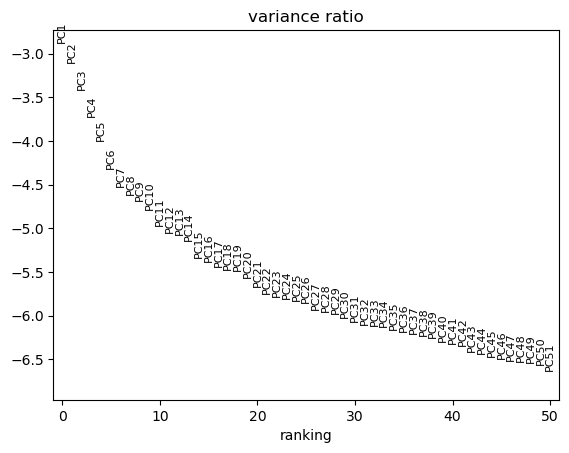

In [97]:
print(f"cummulative variance of {bdata.uns['pca']['variance_ratio'].size} PCs is {bdata.uns['pca']['variance_ratio'].sum():.3f}")
sc.pl.pca_variance_ratio(bdata, log=True, n_pcs=50)

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


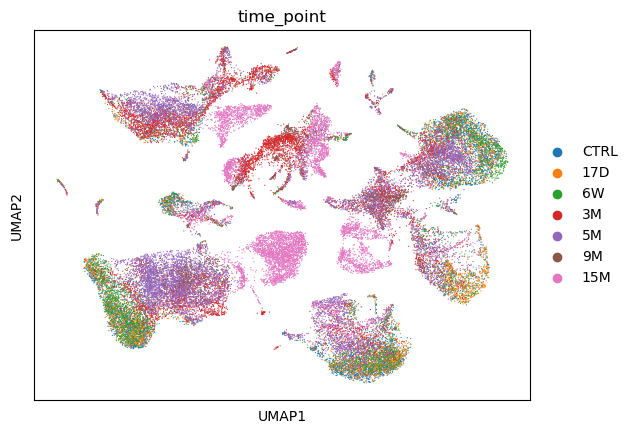

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


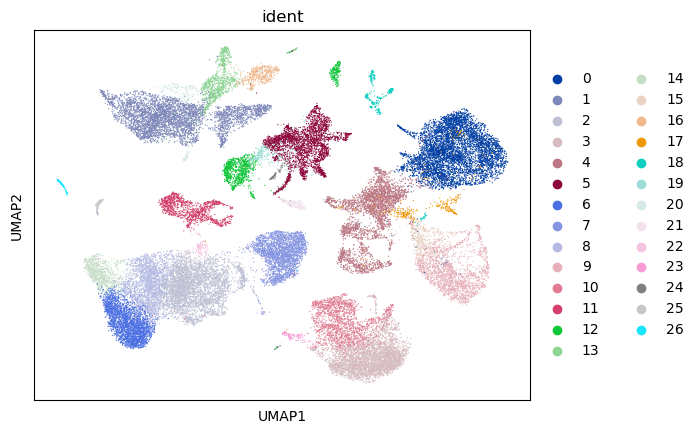

CPU times: user 25.2 s, sys: 12.7 s, total: 37.9 s
Wall time: 17.1 s


In [95]:
%%time
sc.pp.neighbors(bdata, n_neighbors=10, n_pcs=100)
sc.tl.umap(bdata)
sc.pl.umap(bdata, color='time_point')
sc.pl.umap(bdata, color='ident')

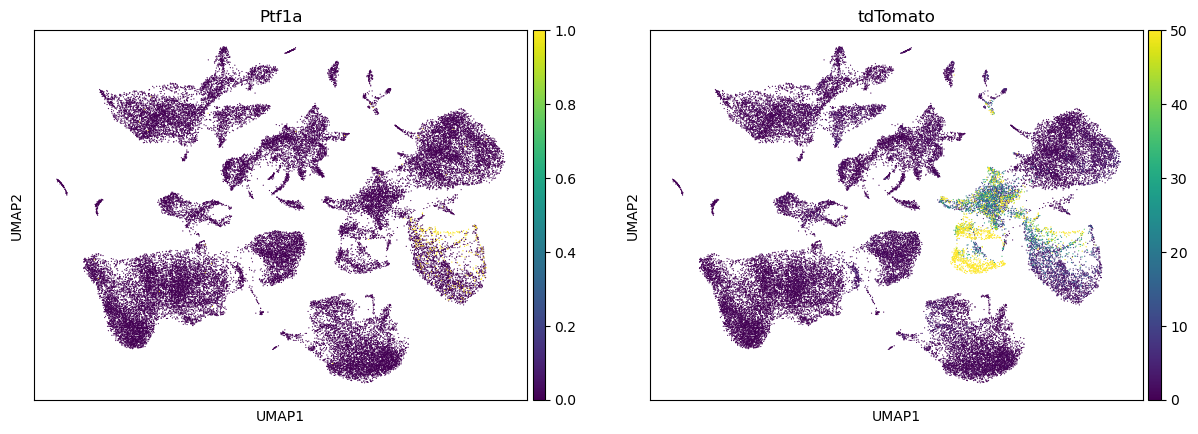

In [ ]:
sc.pl.umap(adata, color=['Ptf1a', 'tdTomato'], vmax=[1, 50])

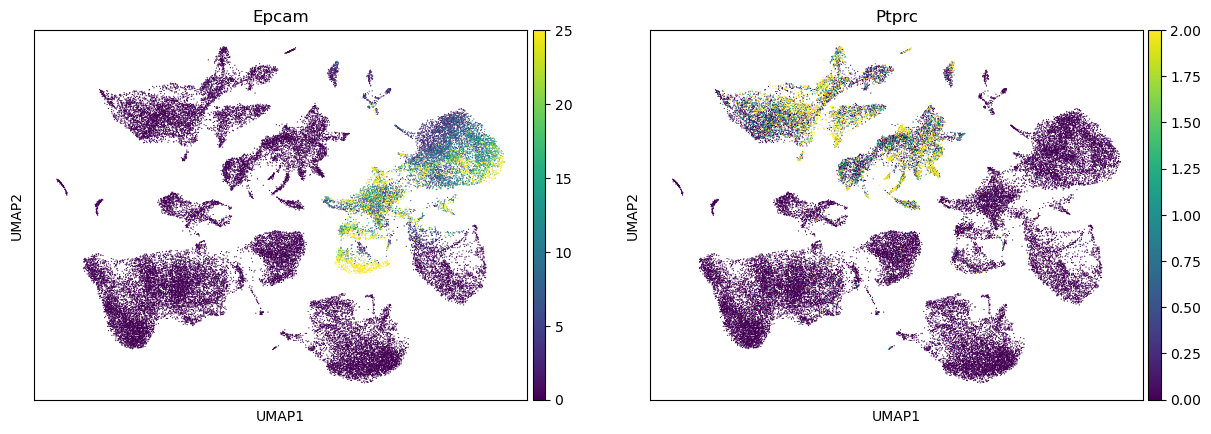

In [158]:
sc.pl.umap(adata, color=['Epcam', 'Ptprc'], vmax=[25, 2])

#### Adding the PCA and UMAP coordinates to the main AnnData object

In [118]:
adata.obsm = bdata.obsm
adata.obsp = bdata.obsp
adata.uns.update(bdata.uns)
adata.uns.pop('log1p')
adata

AnnData object with n_obs × n_vars = 41057 × 18689
    obs: 'ident', 'time_point', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'hvg', 'time_point_colors', 'pca', 'ident_colors', 'neighbors', 'umap', 'time_point_colors_dict', 'ident_colors_dict'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [89]:
for obs_col in ['time_point', 'ident']:
    adata.uns[obs_col + '_colors_dict'] = dict(zip(adata.obs[obs_col].cat.categories, adata.uns[obs_col + '_colors']))

## joint highly variable genes

In [ ]:
_utils.joint_hvg_across_stages(adata, obs_category_key = 'time_point')

### Splitting the adata by "time_point", and creating a normalized variance layer

In [119]:
%%time

times = adata.obs.time_point.cat.categories
split_adatas_dir = _utils.set_dir(results_dir.joinpath('split_adatas'))

for t in times:
    print(f'working on timepoint {t}')
    if not split_adatas_dir.joinpath(f'{t}.h5ad').exists():
        tmp = adata[adata.obs.time_point == t].copy()

        tmp.uns['name'] = f'{t}'   # full name
        tmp.uns['sname'] = f'{t[:3]}'  # short name, truncating CTRL to CTR

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)

        # calculating per sample HVGs
        sc.pp.highly_variable_genes(tmp, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

        tmp.write_h5ad(split_adatas_dir.joinpath(f'{t}.h5ad'))

        del tmp

working on timepoint CTRL
working on timepoint 17D
working on timepoint 6W
working on timepoint 3M
working on timepoint 5M
working on timepoint 9M
working on timepoint 15M
CPU times: user 6 s, sys: 847 ms, total: 6.85 s
Wall time: 10.8 s


### Running multiple NMF iterations

In [112]:
%%time

cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))

ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18] #, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for t in times:
    print(f'Starting on {t}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{t}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, t)
    
    # Variance normalized version of the data
    X = sc.pp.scale(tmp.X[:, tmp.var.highly_variable].toarray().astype(np.float32), zero_center=False)
    
    c_object.prepare(X, ks, n_iter=100, new_nmf_kwargs={'tol': _constants.NMF_TOLERANCE,
                                                        'beta_loss': 'kullback-leibler'})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X
    


Directory "results_schlesinger/cnmf" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results_schlesinger/cnmf
Starting on CTRL
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Combining factorizations for k=16.
Combining factorizations for k=17.
Combining factorizations for k=18.
Starting on 17D
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.


In [114]:
%%time
for t in times:
    print(f'Starting on {t}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, t)
    for thresh in [0.5, 0.4, 0.3]:
        print(f'working on threshold {thresh}')
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=500,
                                  close_fig=True, show_clustering=True, gpu=True)
    


Starting on CTRL, time is 13:27:45
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on 17D, time is 13:30:54
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on 6W, time is 13:33:53
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on 3M, time is 13:36:57
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on 5M, time is 13:40:16
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on 9M, time is 13:43:41
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
Starting on 15M, time is 13:46:44
working on threshold 0.5
working on threshold 0.4
working on threshold 0.3
CPU times: user 59min 18s, sys: 1h 50min 12s, total: 2h 49min 31s
Wall time: 22min 5s


### Selecting the decomposition rank utilizing K-selection plots and PCA variance explained

In [109]:
%%time
df_var = pd.DataFrame()
df_cumulative_var = pd.DataFrame()

n_components = 50

for t in times:
    
    %time tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{t}.h5ad'))
    
    scaled_log1p_tp100k = np.log1p(tmp.X[:, tmp.var.highly_variable] / np.sum(tmp.X, axis=1) * 1e4)
    scaled_log1p_tp100k -= _.mean(axis=0)
    scaled_log1p_tp100k /= _.std(axis=0)
    
    a, b, c, d, = sc.tl.pca(scaled_log1p_tp100k, n_comps=n_components, return_info=True)

    df_var[f'{t}'] = c*100
    df_cumulative_var[f'{t}'] = c.cumsum()*100

CPU times: user 88.4 ms, sys: 58.9 ms, total: 147 ms
Wall time: 964 ms
CPU times: user 116 ms, sys: 193 ms, total: 309 ms
Wall time: 673 ms
CPU times: user 173 ms, sys: 485 ms, total: 657 ms
Wall time: 1.39 s
CPU times: user 191 ms, sys: 468 ms, total: 659 ms
Wall time: 1.18 s
CPU times: user 154 ms, sys: 411 ms, total: 565 ms
Wall time: 2.16 s
CPU times: user 131 ms, sys: 296 ms, total: 427 ms
Wall time: 481 ms
CPU times: user 208 ms, sys: 603 ms, total: 811 ms
Wall time: 1.51 s
CPU times: user 58.6 s, sys: 24.4 s, total: 1min 23s
Wall time: 17.9 s


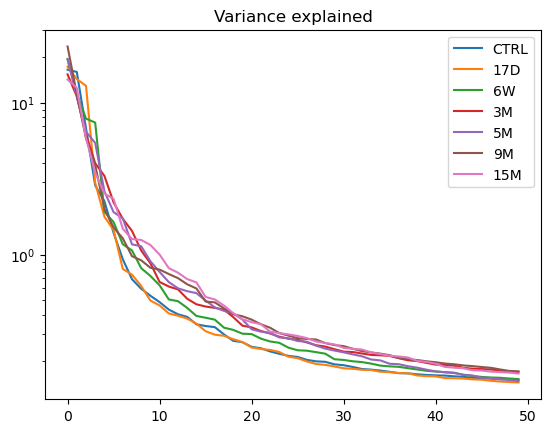

In [110]:
plt.plot(range(50), df_var, label=df_var.columns)
plt.title('Variance explained')
plt.legend()
plt.yscale('log')
plt.show()

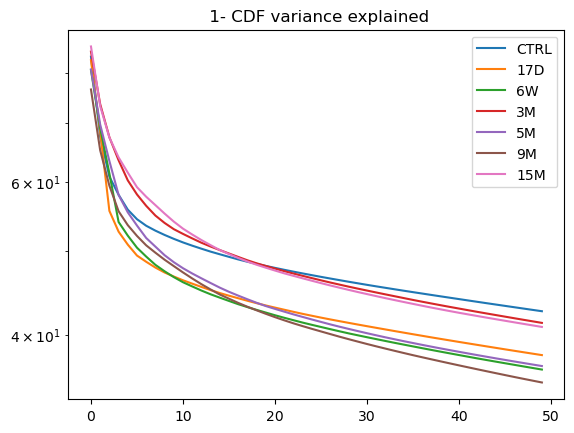

In [111]:
plt.plot(df_cumulative_var.index, 100-df_cumulative_var, label=df_var.columns)
plt.yscale('log')
plt.title(f' 1- CDF variance explained')
plt.legend()
plt.show()

In [148]:
%%time

selected_cnmf_params = {
    'CTRL': (8, 0.5),  # 
    '17D': (9, 0.5),  # 
    '6W': (10, 0.5),    # 
    '3M': (11, 0.5),    # 
    '5M': (11, 0.5),   # 
    '9M': (10, 0.5),  # 
    '15M': (11, 0.5)}   # 

split_adatas = {}

for t, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on {t} with k={k} and threshold={threshold}')
    %time tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{t}.h5ad'))

    c_object = cnmf.cNMF(cnmf_dir, t)
    c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                       nmf_refitting_iters=1000, show_clustering=False)

    usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    tmp.obsm['usages'] = usages.copy()

    usages_norm = usages / np.sum(usages, axis=1, keepdims=True)
    tmp.obsm['usages_norm'] = usages_norm

    # get per gene z-score of data after TPM normalization and log1p transformation 
    tpm_log1p_zscore = tmp.X.toarray()
    tpm_log1p_zscore /= 1e-6 * np.sum(tpm_log1p_zscore, axis=1, keepdims=True)
    tpm_log1p_zscore = np.log1p(tpm_log1p_zscore)
    tpm_log1p_zscore = sc.pp.scale(tpm_log1p_zscore)

    usage_coefs = _utils.fastols(usages_norm, tpm_log1p_zscore)

    tmp.varm['usage_coefs'] = pd.DataFrame(
        usage_coefs.T, index=tmp.var.index,
        columns=[f'{tmp.uns["sname"]}.p{prog}' for prog in range(usages.shape[1])])
    
    split_adatas[t] = tmp

    tmp.write_h5ad(split_adatas_dir.joinpath(f'{t}_GEPs.h5ad'))

Working on CTRL with k=8 and threshold=0.5
CPU times: user 110 ms, sys: 54.2 ms, total: 164 ms
Wall time: 2.47 s
Updating W based on consensus spectra
beta 1 loss = 2727470.25, # iterations was 40
Refitting W, H based on consensus
beta 1 loss = 2699241.75, # iterations was 70
Working on 17D with k=9 and threshold=0.5
CPU times: user 96 ms, sys: 46 ms, total: 142 ms
Wall time: 2.25 s
Updating W based on consensus spectra
beta 1 loss = 1933233.875, # iterations was 50
Refitting W, H based on consensus
beta 1 loss = 1919746.25, # iterations was 100
Working on 6W with k=10 and threshold=0.5
CPU times: user 103 ms, sys: 53.9 ms, total: 157 ms
Wall time: 3.1 s
Updating W based on consensus spectra
beta 1 loss = 1849541.75, # iterations was 50
Refitting W, H based on consensus
beta 1 loss = 1840791.25, # iterations was 70
Working on 3M with k=11 and threshold=0.5
CPU times: user 159 ms, sys: 60.6 ms, total: 219 ms
Wall time: 6.22 s
Updating W based on consensus spectra
beta 1 loss = 4250873.5

### Examening results

In [107]:
%%time

split_adatas = {}
for t in times:
    split_adatas[t] = sc.read_h5ad(split_adatas_dir.joinpath(f'{t}_GEPs.h5ad'))

CPU times: user 2.52 s, sys: 4.66 s, total: 7.18 s
Wall time: 48.9 s


In [149]:
for t in times:
    print(t)
    s = split_adatas[t].obsm['usages_norm'].sum(axis=0)
    with np.printoptions(precision=2, suppress=False):
        print(s * 100 / s.sum())

CTRL
[30.43 26.   24.3   5.38  1.31  4.89  6.09  1.6 ]
17D
[27.03 14.45  5.95 19.99 25.31  1.55  1.02  3.8   0.89]
6W
[15.75  9.67  7.26 23.95 28.24  0.84  1.21  3.31  3.97  5.79]
3M
[10.57  6.91 18.85 10.05 10.78  3.65  2.92  2.42  8.96  1.17 23.73]
5M
[13.78 11.27 15.08  1.85  4.7  20.59  3.04  1.04  9.04 13.11  6.49]
9M
[ 1.88  6.94  2.09 14.66 10.43 16.61 20.97 18.53  4.38  3.51]
15M
[ 4.95  6.71 15.07 30.03  3.05  8.95  0.9  12.97  1.57  8.76  7.04]


## Running comparator on the data

In [154]:
for t in times:
    tmp = split_adatas[t]

    field_1 = 'ident'

    tmp.obsm['row_colors'] = pd.concat([
        tmp.obs[field_1].map(tmp.uns[f'{field_1}_colors_dict']),
        ], axis=1)

In [ ]:
%%time

pairs = [(times[i], times[i + 1]) for i in range(len(times) -1)]

for ta, tb in pairs:
    comparison_dir = _utils.set_dir(results_dir.joinpath(f"{ta}_{stage_b}"))
    
    adata_a = split_adatas[ta]
    adata_b = split_adatas[tb]
    
    if os.path.exists(comparison_dir.joinpath('comparator.npz')):
        cmp = comparator.Comparator.load_from_file(comparison_dir.joinpath('comparator.npz'), adata_a, adata_b)
    else:
        cmp = comparator.Comparator(adata_a, adata_a.obsm['usages'], adata_b, comparison_dir, 'torchnmf', device='cuda', max_nmf_iter=1000, verbosity=1)
        
        print('decomposing')
        cmp.extract_geps_on_jointly_hvgs()
        cmp.decompose_b(repeats = 20)
    
    cmp.examine_adata_a_decomposition_on_jointly_hvgs()
    
    cmp.print_errors()
    cmp.examine_adata_b_decompositions()
    cmp.plot_decomposition_comparisons()
    
    cmp.calculate_fingerprints()
    
    print('running GSEA')
    cmp.run_gsea(gprofiler_kwargs=dict(organism='mmusculus', sources=['GO:BP', 'WP', 'REAC', 'KEGG']))

    cmp.save_to_file(comparison_dir.joinpath('comparator.npz'))

    

## ToDo - plot all programs on phate
## ToDo - consider adding "main program" per cell and plot it on joint tsne and phate

# Epithelial compartment decomposition

### Splitting the adata by "development_stage", retaining only epithelial cells and creating a normalized variance layer

In [123]:
%%time

stages = adata.obs.development_stage.cat.categories
epi_split_adatas_dir = _utils.set_dir(results_dir.joinpath('epi_split_adatas'))

for stage in stages:
    print(f'working on stage {stage}')
    file = epi_split_adatas_dir.joinpath(f'epi_{stage}.h5ad')
    
    if not file.exists():
        tmp = adata[adata.obs.development_stage == stage]
        tmp = tmp[(tmp.obs.compartment == 'epi') & (tmp.obs.celltype != 'unknown3')].copy()
                
        tmp.uns['name'] = f'Epi {stage}'   # full name
        tmp.uns['sname'] = f'{stage}'  # short name, here it is the same

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)

        # calculating per sample HVGs
        sc.pp.highly_variable_genes(tmp, flavor='seurat_v3', n_top_genes=_constants.NUMBER_HVG)

        tmp.write_h5ad(file)

        del tmp

working on stage E12
working on stage E15
working on stage E17
working on stage P3
working on stage P7
working on stage P15
working on stage P42
CPU times: user 11.3 s, sys: 2.87 s, total: 14.2 s
Wall time: 32 s


### Running multiple NMF iterations

In [ ]:
%%time

cnmf_dir = _utils.set_dir(results_dir.joinpath('epi_cnmf'))

ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for stage in stages:
    print(f'Starting on epithelial {stage}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    tmp = sc.read_h5ad(epi_split_adatas_dir.joinpath(f'epi_{stage}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, stage)
    
    # Variance normalized version of the data
    X = sc.pp.scale(tmp.X[:, tmp.var.highly_variable].toarray().astype(np.float32), zero_center=False)
    
    c_object.prepare(X, ks, n_iter=100, new_nmf_kwargs={'tol': _constants.NMF_TOLERANCE,
                                                        'beta_loss': 'kullback-leibler'})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X
    


Directory "results_zepp/epi_cnmf" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results_zepp/epi_cnmf
Starting on epithelial E12, time is 14:48:20
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Combining factorizations for k=13.
Combining factorizations for k=14.
Combining factorizations for k=15.
Starting on epithelial E15, time is 14:53:33


In [134]:
%%time
for stage in stages:
    print(f'Starting on {stage}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, stage)
    for thresh in [0.5, 0.4, 0.3]:
        print(f'working on threshold {thresh}')
        c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=500,
                                  close_fig=True, show_clustering=True, gpu=True)

    


Starting on E12, time is 12:14:12
working on threshold 0.5
CPU times: user 1min 36s, sys: 2min 31s, total: 4min 7s
Wall time: 42.8 s


### Selecting the decomposition rank utilizing K-selection plots and PCA variance explained

In [135]:
%%time
df_var = pd.DataFrame()
df_cumulative_var = pd.DataFrame()

n_components = 30

for stage in stages:
    
    %time tmp = sc.read_h5ad(epi_split_adatas_dir.joinpath(f'epi_{stage}.h5ad'))
    
    a, b, c, d, = sc.tl.pca(tmp.X[:, tmp.var.highly_variable], n_comps=n_components, return_info=True)

    df_var[f'{stage}'] = c*100
    df_cumulative_var[f'{stage}'] = c.cumsum()*100

CPU times: user 152 ms, sys: 23.5 ms, total: 176 ms
Wall time: 2.09 s
CPU times: user 492 ms, sys: 1.06 s, total: 1.55 s
Wall time: 9.57 s
CPU times: user 371 ms, sys: 961 ms, total: 1.33 s
Wall time: 7.98 s
CPU times: user 312 ms, sys: 941 ms, total: 1.25 s
Wall time: 3.41 s
CPU times: user 309 ms, sys: 964 ms, total: 1.27 s
Wall time: 3.43 s
CPU times: user 289 ms, sys: 892 ms, total: 1.18 s
Wall time: 1.27 s
CPU times: user 276 ms, sys: 974 ms, total: 1.25 s
Wall time: 2.41 s
CPU times: user 6.95 s, sys: 21.7 s, total: 28.6 s
Wall time: 32.9 s


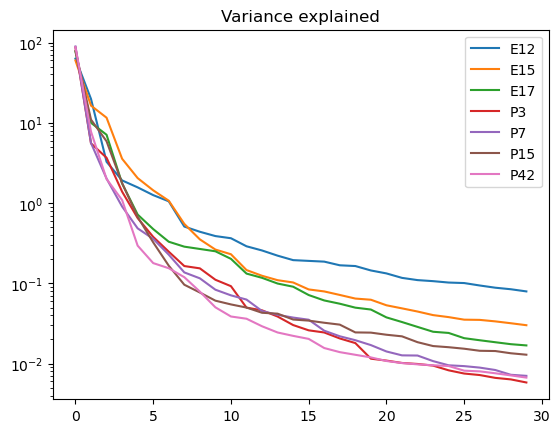

In [138]:
plt.plot(range(len(df_var)), df_var, label=df_var.columns)
plt.title('Variance explained')
plt.legend()
plt.yscale('log')
plt.show()

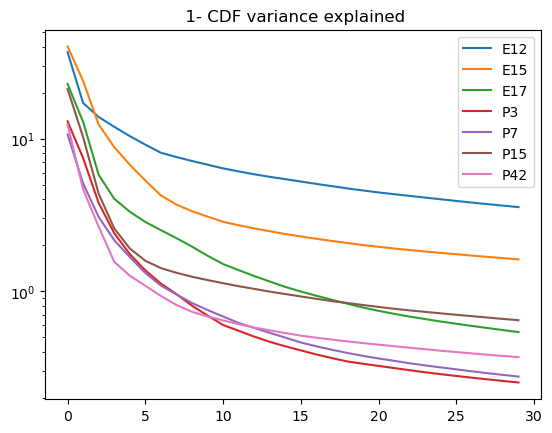

In [139]:
plt.plot(df_cumulative_var.index, 100-df_cumulative_var, label=df_var.columns)
plt.yscale('log')
plt.title(f' 1- CDF variance explained')
plt.legend()
plt.show()

In [140]:
%%time

selected_cnmf_params = {
    'E12': (7, 0.5),  # 
    'E15': (8, 0.5),  # 
    'E17': (10, 0.5),   # 
    'P3': (9, 0.5),    # 
    'P7': (8, 0.5),   # 
    'P15': (5, 0.5),  # 
    'P42': (5, 0.5)}   # 

epi_split_adatas = {}

for stage, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on epi {stage} with k={k} and threshold={threshold}')
    %time tmp = sc.read_h5ad(epi_split_adatas_dir.joinpath(f'epi_{stage}.h5ad'))

    c_object = cnmf.cNMF(cnmf_dir, stage)
    c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                       nmf_refitting_iters=1000, show_clustering=False)

    usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    tmp.obsm['usages'] = usages.copy()

    usages_norm = usages / np.sum(usages, axis=1, keepdims=True)
    tmp.obsm['usages_norm'] = usages_norm

    # get per gene z-score of data after TPM normalization and log1p transformation 
    tpm_log1p_zscore = tmp.X.toarray()
    tpm_log1p_zscore /= 1e-6 * np.sum(tpm_log1p_zscore, axis=1, keepdims=True)
    tpm_log1p_zscore = np.log1p(tpm_log1p_zscore)
    tpm_log1p_zscore = sc.pp.scale(tpm_log1p_zscore)

    usage_coefs = _utils.fastols(usages_norm, tpm_log1p_zscore)

    tmp.varm['usage_coefs'] = pd.DataFrame(
        usage_coefs.T, index=tmp.var.index,
        columns=[f'{tmp.uns["sname"]}.p{prog}' for prog in range(usages.shape[1])])
    
    epi_split_adatas[stage] = tmp

    tmp.write_h5ad(epi_split_adatas_dir.joinpath(f'epi_{stage}_GEPs.h5ad'))

Working on epi E12 with k=7 and threshold=0.5
CPU times: user 158 ms, sys: 24.5 ms, total: 183 ms
Wall time: 1.32 s
Updating W based on consensus spectra
beta 1 loss = 574924.8125, # iterations was 150
Refitting W, H based on consensus
beta 1 loss = 566220.5625, # iterations was 420
Working on epi E15 with k=8 and threshold=0.5
CPU times: user 351 ms, sys: 149 ms, total: 500 ms
Wall time: 6.65 s
Updating W based on consensus spectra
beta 1 loss = 3216023.5, # iterations was 100
Refitting W, H based on consensus
beta 1 loss = 3160945.75, # iterations was 250
Working on epi E17 with k=10 and threshold=0.5
CPU times: user 264 ms, sys: 86.9 ms, total: 351 ms
Wall time: 5.47 s
Updating W based on consensus spectra
beta 1 loss = 1933602.625, # iterations was 100
Refitting W, H based on consensus
beta 1 loss = 1920770.875, # iterations was 180
Working on epi P3 with k=9 and threshold=0.5
CPU times: user 208 ms, sys: 45.7 ms, total: 253 ms
Wall time: 2.78 s
Updating W based on consensus spectr

In [13]:
epidata.obsm_keys()

['X_pca', 'X_tsne', 'X_umap', 'usages', 'usages_norm']

In [16]:
stages = ['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42']
decomposition_images = _utils.set_dir(results_dir.joinpath("epi_split_adatas", "images"))


for stage in stages:
    epidata = sc.read_h5ad(results_dir.joinpath("epi_split_adatas", f"epi_{stage}_GEPs.h5ad"))
    
    # UMAP
    um = sc.pl.umap(epidata, color='celltype', s=10, return_fig=True, title=f'{stage} epithelial')
    plt.tight_layout()
    um.savefig(decomposition_images.joinpath(f"epi_{stage}_umap_celltype.png"), dpi=300)
    plt.close(um)

    # usages clustermap
    un_sns = _utils.plot_usages_norm_clustermaps(
        epidata, title=f'{stage}', show=False,sns_clustermap_params={
            'row_colors': epidata.obs['celltype'].map(epidata.uns['celltype_colors_dict'])})
    un_sns.savefig(decomposition_images.joinpath(f"epi_{stage}_usages_norm.png"),
                   dpi=180, bbox_inches='tight')
    plt.close(un_sns.fig)

    # usages violin plot
    _utils.plot_usages_norm_violin(
        epidata, 'celltype', save_path=decomposition_images.joinpath(
            f'epi_{stage}_norm_usage_per_lineage.png'))

/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/yotamcon/miniconda3/envs/pp_t/lib/python3.9/site-packages/scanpy/plot